In [65]:
import numpy as np
# import dpctl
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [66]:
from munch import DefaultMunch, Munch
params = DefaultMunch()
params.dataset_name = 'AliExpress_NL'
params.dataset_path = './data/'

In [67]:
from datasets import get_dataset
import os
from torch.utils.data import DataLoader
train_dataset = get_dataset(params.dataset_name, os.path.join(
        params.dataset_path, params.dataset_name) + '/train.csv')
test_dataset = get_dataset(params.dataset_name, os.path.join(
    params.dataset_path, params.dataset_name) + '/test.csv')


In [68]:
import joblib
memory = joblib.Memory('./joblib_tmp', verbose=1)
@memory.cache
def get_all_two():
    # X_train = np.hstack((train_dataset.categorical_data, train_dataset.numerical_data))
    X_train = train_dataset.numerical_data
    # X_train = train_dataset.categorical_data
    y_train = train_dataset.labels
    # X_test = np.hstack((test_dataset.categorical_data, test_dataset.numerical_data))
    X_test = test_dataset.numerical_data
    # X_test = test_dataset.categorical_data
    y_test = test_dataset.labels
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = get_all_two()

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf0 = make_pipeline(  StandardScaler(), LogisticRegression(random_state=0))
clf0.fit(X_train, y_train[:, 0])
clf1 = make_pipeline(  StandardScaler(),LogisticRegression(random_state=0))
clf1.fit(X_train, y_train[:, 1])

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_auc(y_test, y_pred, filename):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {filename}')
    plt.legend()
    plt.savefig(f'fig/{filename}.png')
    return roc_auc

def evaluate_and_draw(model, X_test, y_test, model_name='tree', classes=['impression', 'click', 'purchase']):
    print(f"模型自带分数：{model.score(X_test, y_test)}")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    print(f"Precision: {precision_score(y_test, y_pred, average='macro')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
    print(f"F1: {f1_score(y_test, y_pred, average='macro')}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f'log_loss: {log_loss(y_test, y_proba)}')
    # 多分类，取第一类的auc
    auc = plot_auc(y_test, y_proba[:, 1], f'{model_name}_auc') 
    print(f"auc：{auc}")
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.savefig(f'fig/{model_name}.png')

模型自带分数：0.9754881054290818
Precision: 0.6523285728345753
Recall: 0.5005437600178116
F1: 0.49493799345167633
Accuracy: 0.9754881054290818
log_loss: 0.10695392371663699
auc：0.7238458906672873
模型自带分数：0.9991155362877455
Precision: 0.599558486864602
Recall: 0.500202904365304
F1: 0.500185207623601
Accuracy: 0.9991155362877455
log_loss: 0.0060117715038614196
auc：0.864054273394133


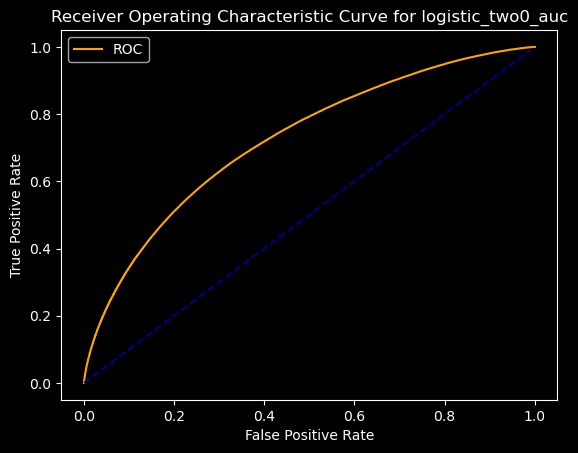

<Figure size 640x480 with 0 Axes>

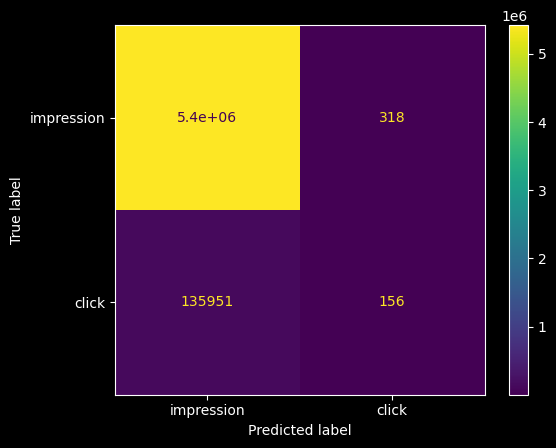

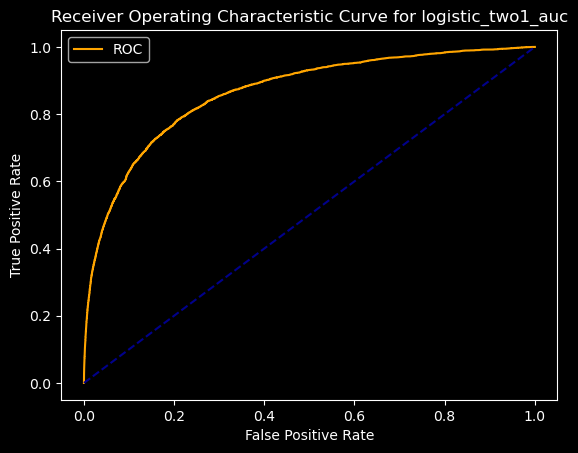

<Figure size 640x480 with 0 Axes>

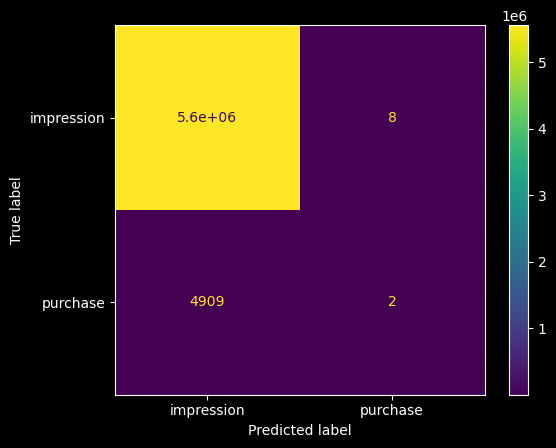

In [ ]:
evaluate_and_draw(clf0, X_test, y_test[:, 0].squeeze(), 'logistic_two0', classes=['impression', 'click'])
evaluate_and_draw(clf1, X_test, y_test[:, 1].squeeze(), 'logistic_two1',  classes=['impression', 'purchase'])

In [82]:
import torch
import torch.nn
class SingleLayerShareBottom(nn.Module):
    """Some Information about SingleLayerNN"""
    def __init__(self, alpha=10):
        super().__init__()
        hid_num = int(X_train.shape[0]/(alpha*(X_train.shape[1]+1))/100)
        print(f'hidden num: {hid_num}')
        self.hidden = nn.Linear(X_train.shape[1], hid_num)
        self.tower = torch.nn.ModuleList([nn.Linear(hid_num, 1) for _ in range(2)])
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = torch.stack([tower(x) for tower in self.tower], dim=1)
        x = torch.sigmoid(x).squeeze()
        return x
net = SingleLayerShareBottom()
net(torch.Tensor(X_train[:2, :])).shape

hidden num: 189


torch.Size([2, 2])

In [83]:
# optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-2)

In [72]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [73]:
criterion = nn.BCELoss()

In [74]:
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

In [75]:
params.batch_size = 2048

In [76]:
train_data_loader = DataLoader(train_dataset, batch_size=params.batch_size,  # sampler=sampler,
                                   num_workers=4, shuffle=True, pin_memory=True)
test_data_loader = DataLoader(test_dataset, batch_size=params.batch_size,
                                  num_workers=4, shuffle=False, pin_memory=True)  # num_workers是GPU数量的四倍。


In [ ]:
next(iter(train_data_loader))[1].shape

torch.Size([2048, 2])

In [84]:
# loop over the dataset multiple times
import tqdm
# net = torch.compile(net, mode="max-autotune")
net = net.to(device)

for epoch in range(100):
    running_loss = 0.0
    for i, data in tqdm.tqdm(enumerate(train_data_loader, 0)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs[:, 0], labels[:, 0]) + criterion(outputs[:, 1], labels[:, 1])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print('Loss: {}'.format(running_loss))

print('Finished Training')

61it [00:00, 88.86it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd605695700>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd605695700>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
  File "/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
  File "/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
  File "/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
        # Existing mechanisms try to make the workers exit# Existing mechanisms try to make the workers exit

  File "/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/multiprocessing/process.py", line 16

Loss: 580.9389695040882



57it [00:00, 98.06it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd605695700>
Traceback (most recent call last):
  File "/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
  File "/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
    # Existing mechanisms try to make the workers exit
  File "/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd605695700>
Traceback (most recent call last):
  File "/home/yecm/anaconda3/envs/torch2.0/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
  File "/home/yecm/anaconda3/envs/torch2.0/lib/python

KeyboardInterrupt: 

auc：[0.7298046523208712, 0.8570687293541775]


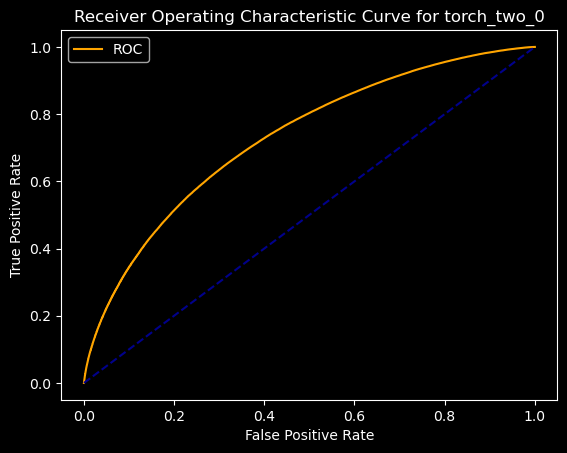

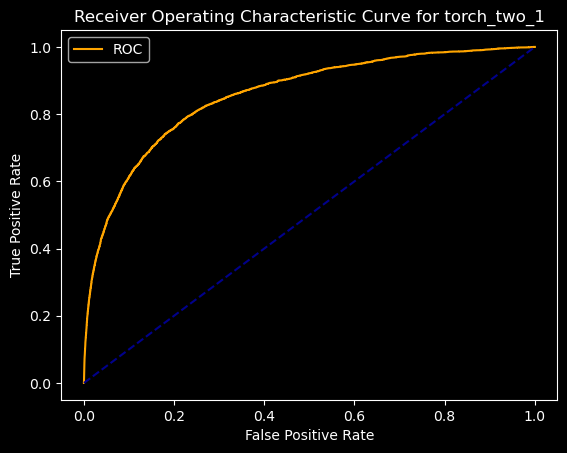

In [94]:
net = net.eval()
with torch.no_grad():
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    y_prob = net.to()device(torch.Tensor(X_test).to(device))
    y_prob = y_prob.cpu().numpy()
    y_test = y_test.squeeze()
    auc = [plot_auc(y_test[:, i], y_prob[:, i], f'torch_two_{i}') for i in range(2)]
    print(f"auc：{auc}")